# Финальный проект Karpov.Courses

### Задание 1. A/B–тестирование
#### Условие 
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 
В качестве задания необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

#### Входные данные

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)    
groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных  
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.   
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

#### Вопросы

Предлагаем Вам ответить на следующие вопросы:

- На какие метрики Вы смотрите в ходе анализа и почему?  
- Имеются ли различия в показателях и с чем они могут быть связаны?  
- Являются ли эти различия статистически значимыми?  
- Стоит ли запускать новую механику на всех пользователей?  


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy import stats 
import statsmodels.api as sm

Считаем данные и посмотрим на их структуру

In [19]:
base_url = 'https://getfile.dokpub.com/yandex/get/'
groups = pd.read_csv(base_url + 'https://disk.yandex.ru/d/UhyYx41rTt3clQ', sep=';') 
groups_add = pd.read_csv(base_url + 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ') 
active_studs = pd.read_csv(base_url + 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ') 
checks = pd.read_csv(base_url + 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA', sep=';') 

In [22]:
# если ссылки не работают, использую локальные файлы:
# groups = pd.read_csv('./data/groups.csv', sep=';') 
# groups_add = pd.read_csv('./data/group_add.csv') 
# active_studs = pd.read_csv('./data/active_studs.csv') 
# checks = pd.read_csv('./data/checks.csv', sep=';') 

In [3]:
print(groups.info())
groups.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None


,id,grp
0,1489,B
1,1627,A
2,1768,B


In [4]:
print(groups_add.info())
groups_add.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
None


,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [5]:
print(active_studs.info())
active_studs.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
None


,student_id
0,581585
1,5723133
2,3276743


In [6]:
print(checks.info())
checks.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB
None


,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


Проверим на наличие повторных оплат (совпадает ли число уникальных ID с числом строк в датасете)

In [9]:
checks.student_id.nunique()

541

Объединим данные в один датасет

In [23]:
# 1) соединим вертикально датасеты с id и группами
df = pd.concat([groups, groups_add], ignore_index=True)

# 2) на основе active_studs добавим столбец active, помечающий пользователей, зашедших на платформу в дни эксперимента
active_studs[['active']] = 'Y'
df = df.rename(columns={'id': 'student_id'})
df = df.merge(active_studs, how='left', on='student_id')

# 3) на основе checks добавим столбец с информацией об оплатах пользователей в дни проведения эксперимента
df = df.merge(checks, how='left', on='student_id')

In [12]:
# проверим результат объединения
df.head()

,student_id,grp,active,rev
0,1489,B,NaN,NaN
1,1627,A,Y,990.0
2,1768,B,NaN,NaN
3,1783,B,NaN,NaN
4,1794,A,NaN,NaN


Проверим есть ли пользователи, НЕ участвующие в эксперименте, но с наличием оплаты в это время (просто для информации)

In [9]:
df.loc[df.active.isna() & df.rev.notna(),].grp.value_counts()

B    120
A     29
Name: grp, dtype: int64

### Логика решения
- В анализ возьмем только активных в дни эксперимента пользователей, несмотря на то, что есть и данные по оплатам у тех, кто не заходил на платформу в эти дни.
- Посмотрим на метрику CR (в покупку) и сравним ее в группах. Ответим на вопрос "влияет ли новая механика оплаты на увеличение доли платящих пользователей".
- Посмотрим на метрику ARPPU и сравним ее в группах. Ответим на вопрос "влияет ли новая механика оплаты на средний доход на платящего пользователя". В данных нет информации о числе повторных покупок. Если у каждого пользователя была только одна покупка, то эта метрика совпадает с метрикой "средний чек". 
- Посмотрим на метрику ARPU и сравним ее в группах. Ответим на вопрос "влияет ли новая механика оплаты на средний доход с привлечённого пользователя".

**Обоснование выбора метрик**

CR в покупку  
Возможно часть пользователей отваливается на этапе перехода на страницу оплаты из-за неудобной механики, и в нашем эксперименте пробуют улучшить именно страницу оплаты. Также может быть, что новая механика оплаты находится сразу на странице товара, например, добавили опцию взять товар в рассрочку или кнопку для быстрого оформления заказа. В таком случае пользователи привлекаются на более раннем этапе воронки.


ARPPU   
Обычно экран оплаты появляется после выбора товаров, т. е. в таком случае новая механика оплаты может повлиять на ARPPU разве что косвенно, через число повторных покупок. Но возможно, что новая механика оплаты отражается как-то сразу рядом с товаром. Например, возможность оформить рассрочку увеличивает число дорогих покупок, но при этом не влияет значимо на общее число покупок (CR).

ARPU  
Скорее дополнительная метрика для общей картины, интересно сопоставить ее с ARPPU.

Подготовим датасет для анализа:

In [24]:
# оставим только пользователей, участвующих в экперименте
df_active = df.loc[df.active == 'Y', ['student_id', 'grp', 'rev']].reset_index(drop=True)

In [40]:
# добавим столбец с флагом платежа
df_active['payfl'] = 'N'
df_active['payfl'] = df_active['payfl'].where(df_active.rev.isna(), 'Y')
df_active.head()

,student_id,grp,rev,payfl
0,1627,A,990.0,Y
1,2085,B,NaN,N
2,2215,B,NaN,N
3,3391,A,NaN,N
4,3401,B,NaN,N


**Оценим CR**

In [26]:
# создадим таблицу сопряженности для проведения стат. теста
contigency = pd.crosstab(df_active['grp'], df_active['payfl']) 

# та же таблица, но с процентами в группах, позволяет посмотреть на conversion rates (столбец payfl = Y)
contigency_perc = pd.crosstab(df_active['grp'], df_active['payfl'], normalize='index') * 100
round(contigency_perc, 2)

payfl,N,Y
grp,,
A,94.93,5.07
B,95.38,4.62


In [27]:
# сравним группы хи квадрат тестом
chi2, pval, dof, expected = chi2_contingency(contigency)
round(pval, 4)

0.4863

**Оценим ARPPU**  
  
Посмотрим на характер распределения данных по оплатам в группах

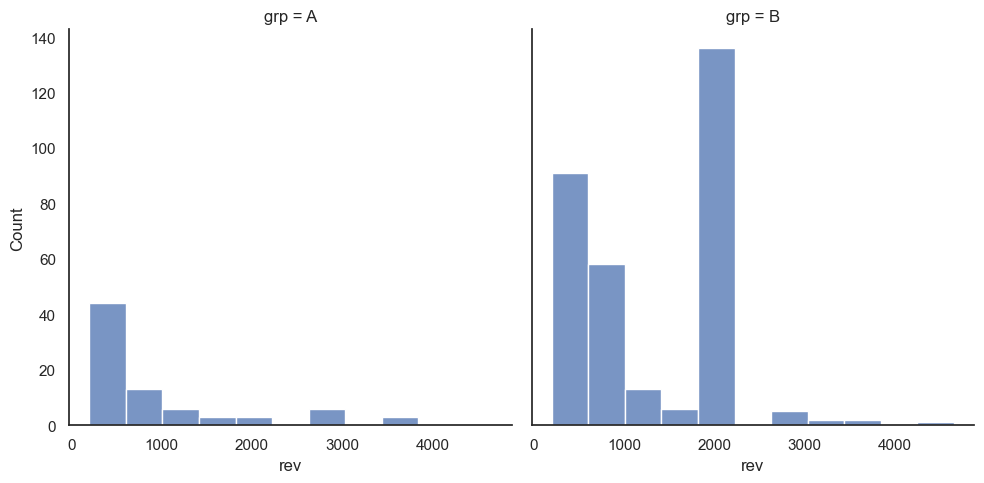

In [63]:
# построим гистограммы по группам
sns.set(style='white', rc={'figure.figsize': (10, 5)})
sns.displot(data=df_active, x='rev', col='grp')

По графику видно, что в группе B выросло число покупок на сумму около 2000, посмотрим как выглядят конкретные значения:

In [64]:
# посчитаем частоты конкретных сумм покупок 
df_active.groupby('grp').rev.value_counts(normalize=True)

grp  rev      
A    290.0000     0.320513
     580.0000     0.076923
     199.0000     0.064103
     590.0000     0.064103
     990.0000     0.064103
     690.0000     0.051282
     840.0000     0.038462
     1530.0000    0.038462
     3660.0000    0.038462
     489.0000     0.025641
     1140.0000    0.025641
     1160.0000    0.025641
     2820.0000    0.025641
     2910.0000    0.025641
     398.0000     0.012821
     870.0000     0.012821
     1039.0000    0.012821
     1180.0000    0.012821
     1830.0000    0.012821
     1980.0000    0.012821
     2220.0000    0.012821
     2890.0000    0.012821
     2900.0000    0.012821
B    1900.0000    0.296178
     290.0000     0.143312
     1900.0001    0.111465
     199.0000     0.085987
     840.0000     0.066879
     990.0000     0.054140
     690.0000     0.041401
     1140.0000    0.028662
     398.0000     0.019108
     590.0000     0.019108
     580.0000     0.015924
     870.0000     0.015924
     1530.0000    0.015924
     2099.000

Сравним группы с помощью t-test:

In [133]:
stat, pval = stats.ttest_ind(
    df_active.query("(grp == 'A') & (rev.notna())").rev, 
    df_active.query("(grp == 'B') & (rev.notna())").rev)

round(pval, 4)

0.0019

Описательная статистика в группах:

In [18]:
df_active.groupby('grp').rev.describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,78.0,933.589744,919.932711,199.0,290.00,585.0,1114.75,3660.0
B,314.0,1257.878992,790.864254,199.0,511.75,1140.0,1900.00,4650.0


**Оценим ARPU**

Сравним группы с помощью t-test:

In [135]:
# добавим копию столбца rev, заменив NaN на 0
df_active['rev0'] = df_active['rev'].where(df_active['rev'].notna(), 0)

# t-test
stat, pval = stats.ttest_ind(
    df_active.query("(grp == 'A')").rev0, 
    df_active.query("(grp == 'B')").rev0)

round(pval, 4)

0.2205

Описательная статистика в группах:

In [136]:
df_active.groupby('grp').rev0.describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,1538.0,47.347204,290.490632,0.0,0.0,0.0,0.0,3660.0
B,6803.0,58.058798,313.770201,0.0,0.0,0.0,0.0,4650.0


### Выводы

1. Результаты
    - Конверсия в группе A: 5.07%, в группе B: 4.62%, значимых различий не обнаружено (p = 0.4863).
    - ARPPU в группе A: 933.6, в группе B: 1257.9, показаны значимые различия (p = 0.0019).
    - ARPU в группе A: 47.3, в группе B: 58.1, значимых различий не обнаружено (p = 0.2205).

  
2. Интерпретация результатов
    - Беря во внимание графики распределений, возрастание ARPPU можно объяснить сильно выросшим числом оплат на сумму 1900. Скорее всего новая механика оплаты повлияла не на конверсию вообще, а на увеличение числа покупок определенного товара/услуги.
    - Также в данных нет информации о числе совершенных платежей каждым пользователем, но предположим, что покупок у одного пользователя могло быть несколько. Тогда возможно, что новая механика оплаты влияет на самом деле на повторные покупки.
  
  
3. Выводы
    - Прежде чем запускать новую механику на пользователей стоит лучше понять природу различий, но в целом, в силу значимого увеличения среднего чека, скорее всего это будет оправдано. 

### Задание 3. Python

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

**1.**  
Дополнительные предположения о том, что не оговорено в условии:
1) путь к файлу groups_add.csv будет передаваться через параметр add_file  
2) порядок и набор столбцов в groups_add.csv такой же, как и в имеющемся датасете   
3) df и groups_add.csv уже содержат данные об оплатах, никакие дополнительные фильтры также не требуются  
4) столбец с оплатой называется rev  
5) значения метрик возвращаются в одном датафрейме


In [76]:
# df - текуший датасет
# add_file - путь к дополнительному файлу 
def update_results(df, add_file):
    '''Подгружает в df информацию из дополнительного файла add_file
    и на основании дополнительных параметров возвращает пересчитанные метрики CR, ARPPU, ARPU'''
    
    # считаем файл и переименуем столбцы именами как в df 
    groups_add = pd.read_csv(add_file) 
    groups_add.columns = list(df.columns)
    
    # объединим датасеты
    df_upd = pd.concat([df, groups_add], ignore_index=True)
    
    # добавим копию столбца rev, заменив NaN на 0
    df_upd['rev0'] = df_upd['rev'].where(df_upd['rev'].notna(), 0)
    
    # считаем метрики в группах
    metrics = df_upd.groupby('grp', as_index=False).agg(CR=('rev', lambda x: (x.notna().sum() * 100) / x.shape[0]),
                                                        ARPPU=('rev', 'mean'),
                                                        ARPU=('rev0', 'mean'))
    
        
    # приведем датафрейм в вертикальный формат
    metrics = pd.melt(metrics, id_vars=['grp'])

    return metrics

**2.**  
Дополнительные предположения о том, что не оговорено в условии:  
1) на вход подается датафрейм в том же формате, в каком он выводится в функции update_results  
2) функция отрисовывает все метрики сразу

In [73]:
def metrics_vis(df):
    '''Принимает df со значениями метрик в группах (названия столбцов grp, variable, value) и строит по ним графики'''

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.tight_layout(pad=3)

    i = 0
    for m in df.variable.unique():
        sns.barplot(ax=axs[i], data=df.loc[df.variable == m,], x='grp', y='value')
        axs[i].set_title(m)
        axs[i].set(xlabel='group')
        i += 1

    plt.show()

In [65]:
# проверка работы функций
# df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/UhyYx41rTt3clQ', sep=';') 
# groups_add = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/5Kxrz02m3IBUwQ') 

In [82]:
# df = df.rename(columns={'id': 'student_id'})
# df = df.merge(checks, how = 'left', on='student_id')
# df = df.merge(df_active.student_id, on='student_id')
# df.head(3)

In [83]:
# groups_add = groups_add.rename(columns={'id': 'student_id'})
# groups_add = groups_add.merge(checks, how = 'left', on='student_id')
# groups_add = groups_add.merge(df_active.student_id, on='student_id')
# df.head(3)

In [68]:
# groups_add.to_csv('groups_add.csv', index=False)

In [84]:
# update_results(df, 'groups_add.csv')

In [89]:
# print(update_results.__doc__)

In [86]:
# metrics_vis(update_results(df, 'groups_add.csv'))